In [1]:
import numpy as np
import math
import matplotlib.pyplot as plt
import random
import pandas as pd

### Robot Parameters

In [2]:
radius = 20
noSegments = 1
segLength = 340

### Transformation Functions

In [3]:
def actuator_to_configSpace(Tl):
    '''
    Perform Transformation from actuator to configuration space for 4 tendon continuum robot
    
    Input: 
        Tl -- list consisting of tendon lengths
    Output:
        k -- Robot Curvature
        l -- Robot length
        phi -- Bending angle
    '''
    pi = math.pi
    if Tl[2]==Tl[0] and Tl[3]==Tl[1] and Tl[2]==Tl[3]:
        phi = 0
    elif Tl[2]==Tl[0] and Tl[3]==Tl[1]:
        phi = pi/4
        if Tl[3]>Tl[0]:
            phi = -pi/4
    elif Tl[2]==Tl[0]:
        phi = pi/2
    else:
        phi = math.atan((Tl[3]-Tl[1])/(Tl[2]-Tl[0]))
        if Tl[1]>Tl[3] and Tl[0]>Tl[2]:
            phi+=pi
        elif Tl[3]>Tl[1] and Tl[2]<Tl[0]:
            phi = pi - abs(phi)
            

    if Tl[2]==Tl[0] and Tl[3]==Tl[1] and Tl[2]==Tl[3]:
        k = 0
    elif Tl[3]==Tl[1] and Tl[2]==Tl[0]:
        k = (Tl[0]-3*Tl[1]+Tl[2]+Tl[3])*math.sqrt(2)/(radius*sum(Tl))
    elif Tl[3]==Tl[1]:
        k = (Tl[1]-3*Tl[0]+Tl[2]+Tl[3])*math.sqrt((Tl[3]-Tl[1])**2+(Tl[2]-Tl[0])**2)/(radius*sum(Tl)*(Tl[2]-Tl[0]))
    else:
        k = (Tl[0]-3*Tl[1]+Tl[2]+Tl[3])*math.sqrt((Tl[3]-Tl[1])**2+(Tl[2]-Tl[0])**2)/(radius*sum(Tl)*(Tl[3]-Tl[1]))

    l = sum(Tl)/4
    return k,l,phi

In [4]:
def rotation(ax=[0,0,1],tht=0):
    [x,y,z] = ax
    c = math.cos(tht)
    s = math.sin(tht)
    R = [[(1-c)*x**2+c,(1-c)*x*y-s*z,(1-c)*x*z+s*y],
         [(1-c)*x*y+s*z,(1-c)*y**2+c,(1-c)*z*y-s*x],
         [(1-c)*x*z-s*y,(1-c)*z*y+s*x,(1-c)*z**2+c]]
    R= np.array(R)
    return R

In [5]:
def transform(rot,trans):
    Tr = np.append(rot,trans,axis=1)
    Tr = np.append(Tr,[[0,0,0,1]],axis=0)
    return Tr

In [6]:
def config_to_taskSpace(k,l,phi):
    
    p0 = [[0],[0],[0]]
    if k == 0:
        p = [[0],[0],[l]]
    else:
        p = [[(1-math.cos(k*l))/k],[0],[math.sin(k*l)/k]]

    Tbr = transform(rotation(tht=phi),p0)
    theta = k*l
    Trt = transform(rotation(ax=[0,1,0],tht=theta),p)
    Ttm = transform(rotation(tht=-phi),p0)
    
    Tf = np.matmul(Tbr,Trt)
    Tf = np.matmul(Tf,Ttm)
    return Tf

In [7]:
def rotation_quaternion(R):
    
    tr = np.trace(R)
    
    if tr>0:
        S = math.sqrt(tr+1)*2
        qw = 0.25 * S
        qx = (R[2][1] - R[1][2])/S
        qy = (R[0][2] - R[2][0])/S 
        qz = (R[1][0] - R[0][1])/S
    elif (R[0][0] > R[1][1]) and (R[0][0] > R[2][2]):
        S = math.sqrt(1+R[0][0]-R[1][1]-R[2][2])*2
        qw = (R[2][1] - R[1][2])/S
        qx = 0.25 * S
        qy = (R[0][1] + R[1][0])/S
        qz = (R[0][2] + R[2][0])/S 
    elif (R[1][1] > R[2][2]):
        S = math.sqrt(1+R[1][1]-R[0][0]-R[2][2])*2
        qw = (R[2][0] - R[0][2])/S
        qx = (R[0][1] + R[1][0])/S
        qy = 0.25 * S
        qz = (R[1][2] + R[2][1])/S 
    else:
        S = math.sqrt(1+R[2][2]-R[0][0]-R[1][1])*2
        qw = (R[1][0] - R[0][1])/S
        qx = (R[0][2] + R[2][0])/S 
        qy = (R[2][1] + R[1][2])/S
        qz = 0.25 * S 
    
    return [qw,qx,qy,qz]

### Input Parameter Dataset

In [8]:
# pi = math.pi
# K = np.arange(0,pi/(2*segLength),0.00004)
# l = segLength
# PHI= np.arange(0,2*pi,0.01)
# position = []
# param = []
# for i in range(K.shape[0]):
#     for j in range(PHI.shape[0]):
#         T = config_to_taskSpace(K[i],l,PHI[j])
#         param.append([K[i],l,PHI[j]])
#         position.append(T[:3,-1])

In [9]:
position=[]
orientation = []
config=[]
pi = math.pi
inputLength = []
normal = [340,340,340,340]
for l1 in range(segLength-30,segLength+31):
    for l2 in range(segLength-30,segLength+31):
        for l3 in range(segLength-30,segLength+31):
            for l4 in range(segLength-30,segLength+31):
                #value = np.random.randint(-30,30,4)
                length = [l1,l2,l3,l4]
#                 if len(Actcuator)!=0 and (length == Actcuator).any():
#                     print("Helo")
#                     continue
                k,l,phi = actuator_to_configSpace(length)
                if abs(k*l)>pi/2:
                    continue
                T = config_to_taskSpace(k,l,phi)
                quat = rotation_quaternion(T[0:3,0:3])
                orientation.append(quat)
                inputLength.append(length)
                position.append(T[:3,-1])

In [10]:
inputLength = np.array(inputLength)
position = np.array(position)
orientation = np.array(orientation)

### Workspace

In [11]:
xdata = []
ydata = []
zdata = []
for i in range(len(position)):
    if position[i][2]<400:
        xdata.append(position[i][0])
        ydata.append(position[i][1])
        zdata.append(position[i][2])

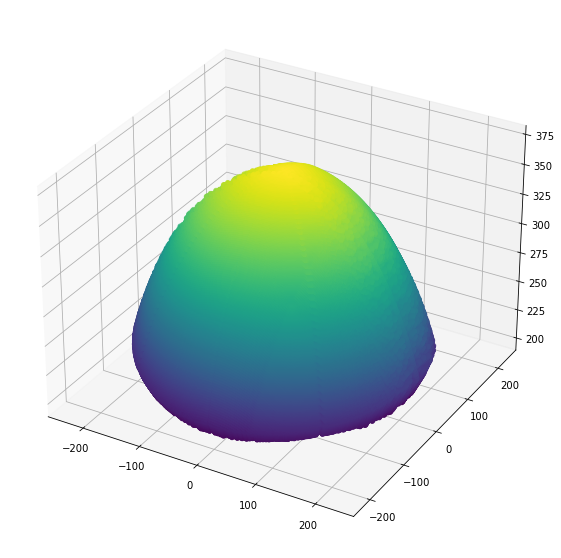

In [12]:
fig = plt.figure(figsize=(10, 10))
ax = fig.add_subplot(111, projection='3d')
ax.scatter3D(xdata, ydata, zdata, c=zdata);

In [13]:
arr = np.concatenate((position,orientation,inputLength),axis=1)
df = pd.DataFrame(arr) 

In [14]:
df.to_csv("CompleteWorkspace.csv")

In [15]:
index = np.random.randint(0,position.shape[0]-1,30000)
positionRandom = position[index]
LengthRandom = inputLength[index]
OrRandom = orientation[index]

In [16]:
xdata = []
ydata = []
zdata = []
for i in range(len(positionRandom)):
    if positionRandom[i][2]<400:
        xdata.append(positionRandom[i][0])
        ydata.append(positionRandom[i][1])
        zdata.append(positionRandom[i][2])

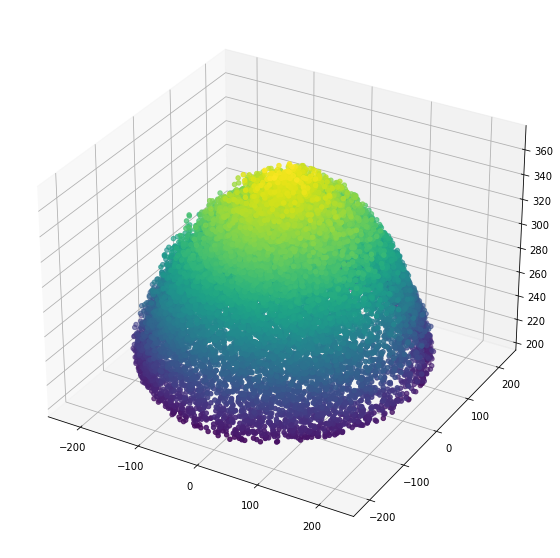

In [17]:
fig = plt.figure(figsize=(10, 10))
ax = fig.add_subplot(111, projection='3d')
ax.scatter3D(xdata, ydata, zdata, c=zdata);

In [18]:
arr = np.concatenate((positionRandom,OrRandom,LengthRandom),axis=1)
df = pd.DataFrame(arr) 

In [19]:
df.to_csv("MLDataset_quat.csv")